In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from bs4 import BeautifulSoup
import requests
import re
from sklearn.cluster import KMeans 
%matplotlib inline
import ast
import json
#!conda install -c conda-forge helper
#import helper
!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library
import matplotlib.cm as cm
!pip install helper
import helper
print('Libraries imported.')


Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.3.9   |       hecc5488_0         146 KB  conda-forge
    certifi-2019.3.9           |           py36_0         149 KB  conda-forge
    conda-4.6.8                |           py36_0         876 KB  conda-forge
    openssl-1.1.1b             |       h14c3975_1         4.0 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         5.1 MB

The following packages will be UPDATED:

  ca-certificates                     2018.11.29-ha4d7672_0 --> 2019.3.9-hecc5488_0
  certifi                              2018.11.29-py36_1000 --> 2019.3.9-py36_0
  conda                                        4.6.4-py36_0 --> 4.6

## Objective: 


The goal is to engage acquired data science and ML skills to perform exploratory analysis on socio economic conditions between different municipalities (kommunes) in Norway. <br>
The findings might help anyone contemplating on moving to Norway to get an insight on which kommunues have better socio economic conditions to live.<br> 
It can also help anyone who wants to get an indepth understanding of Norway.

## Data 1 - Let us collect main figures for each municipalities from statistics website

Using beautifulsoup to extract data from Norwegian statistics website www.ssb.no 
There are 421 kommunes (municipalities) in Norway. First we collect the list of kommunes. 
Then we open url for each municipalities to scrape necessary information. 

In [ ]:
# Each kommune has url as this https://www.ssb.no/kommunefakta/xxxx
# Intil url
page = requests.get('https://www.ssb.no/kommunefakta/')
soup = BeautifulSoup(page.content, "html.parser")

# To generate list of kommune names from initial url  (as appear on url)
def get_kommunes():
    kommunes = []
    kommune_url = soup.find('', id="kommune-liste").contents
    for i in kommune_url:
        if i == '\n':
            pass
        else:
            kommunes.append(re.sub(r'^/kommunefakta/',"",i.a.get('href')))
    return kommunes

# Url with kommune name for each kommune
def choose_kommune(kommunename):
    url_base = 'https://www.ssb.no/kommunefakta/'
    url = url_base + kommunename
    return url
    
# Get total population figure
def get_population():
    population = re.sub(r'\D',"",soup.find('', class_="tall").text)
    return [population]
# Get people with different immigration background
def get_img():
    img = soup.find('', id="highcharts-datatable-325913").descendants
    img_type = ["sweden", "lithuania", "poland", "turkey","eritrea","somalia","phillipines","irak", "pakistan", "vietnam"]
    img_count = []
    for i in img:
        if str(i).isdigit():
            img_count.append(i)
    img = dict(zip(img_type,img_count))
    return img_count

# Get education level
def get_educationlevel():
    education = soup.find('', id="highcharts-datatable-285358").descendants
    education_type = ["primary", "secondary", "university_short", "university_long","no_education"]
    education_count = []
    for i in education:
        if str(i).isdigit():
            education_count.append(i)
    education = dict(zip(education_type,education_count))
    return education_count


# Religion - people registered with Norway church and other faiths
def get_religion():
    norsk_chris = list(soup.find('', id="kommunefaktatall-317475").descendants)
    norsk_chris = norsk_chris[8].span.previous_element
    other_faith = list(soup.find('', id="kommunefaktatall-317473").descendants)
    other_faith = other_faith[8].span.previous_element
    return [norsk_chris, other_faith]

# Kommunes income in percentage
def get_kincome():
    kincome = soup.find('', id="okonomi").p.next_element
    return [kincome]     

# Individual economy
def get_economy():
    loan_percapita = soup.find('', id="kommunefaktatall-285209").span.previous_element
    income_percapita = soup.find('', id="kommunefaktatall-285210").span.previous_element
    expenses_percapita = soup.find('', id="kommunefaktatall-285214").span.previous_element
    return [loan_percapita, income_percapita, expenses_percapita]

# Column names to be used in csv file
column_name = ["kommune", "population", "education_primary", "education_secondary", "education_university_short",
 "education_university_long", "no_education", "religion_christian", "religion_other",  
 "kommune_income_perc", "debt_percapita", "income_percapita", "expenditure_percapitta",
 "img_sweden", "img_lithuania", "img_poland", "img_turkey","img_eritrea","img_somalia",
 "img_phillipines","img_irak", "img_pakistan", "img_vietnam"]
# Collect all functions in one variable so that all can be run in one loop later.
functions = [get_population, get_educationlevel, get_religion, get_kincome, get_economy,get_img]

## get list of all kommunes from ssb webpage
kommunes = get_kommunes() 
# Initialise rows so each kommune figures will populate
rows_list = [] 

#a=0 # Use for test run
## Execute kommunes one by one in the kommunes list
for kommune in kommunes: 
    # First element is kommune name
    count = [kommune] 
    # get full url
    url = choose_kommune(kommune) 
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")
    for func in functions: 
        try:
            count += func()
        except:
            count += ["N/A"]
    # Append kommune names to every row
    rows_list.append(count) 
    print(count)
    

###output file to excel ###
dfKommune = pandas.DataFrame(data = rows_list, columns = column_name) 

dfKommune.to_excel('Norwaykommunedata_SSB.xlsx')

I have run these codes and have generated an excel file. I will use it directly instead of 400 iterations here. 

In [2]:
# Read excel 
df_ssb0= pd.read_excel('/resources/data/Norwaykommunedata_SSB.xlsx')
# Lets check the data type of each column
df_ssb0.dtypes

Unnamed: 0                      int64
kommune                        object
population                      int64
education_primary             float64
education_secondary           float64
education_university_short    float64
education_university_long     float64
no_education                  float64
religion_christian            float64
religion_other                float64
kommune_income_perc           float64
debt_percapita                float64
income_percapita              float64
expenditure_percapitta        float64
img_sweden                      int64
img_lithuania                   int64
img_poland                      int64
img_turkey                      int64
img_eritrea                     int64
img_somalia                     int64
img_phillipines               float64
img_irak                      float64
img_pakistan                  float64
img_vietnam                   float64
dtype: object

In [3]:
## Just inspect
df_ssb0.iloc[100:150,8:18].head(10)

religion_christian  religion_other  kommune_income_perc  debt_percapita  \
100                73.1            11.8                  3.2         76325.0   
101                76.5             9.1                  0.8         51678.0   
102                84.3             5.4                 -0.3        113929.0   
103                76.7             8.0                 -0.3         98532.0   
104                82.7             6.7                  2.5         58209.0   
105                83.2             4.6                  6.4         46033.0   
106                83.0             6.0                  2.8         72784.0   
107                80.7             6.5                  2.8         94273.0   
108                67.7            15.9                 -0.1         56692.0   
109                81.2             5.9                  2.0        164578.0   

     income_percapita  expenditure_percapitta  img_sweden  img_lithuania  \
100           77760.0                 75031.0          18            143   
101           86901.0                 85417.0         152            178   
102          105873.0                105144.0          11             67   
103          120278.0                118772.0          25             58   
104           83503.0                 80874.0          45            181   
105          117193.0                113267.0          16             53   
106          109152.0                107966.0           3              0   
107          149893.0                146630.0          20             11   
108           81171.0                 82136.0          91            183   
109          149056.0                146011.0          12              3   

     img_poland  img_turkey  
100         363         185  
101         435         112  
102          64          12  
103         141          14  
104         135          37  
105           0          11  
106          35          12  
107          29           3  
108         496         153  
109          57          13

In [4]:
### Simply drop rows with nan values.
df_ssb0.dropna(axis=0, inplace = True)

In [5]:
df_ssb0.dtypes

Unnamed: 0                      int64
kommune                        object
population                      int64
education_primary             float64
education_secondary           float64
education_university_short    float64
education_university_long     float64
no_education                  float64
religion_christian            float64
religion_other                float64
kommune_income_perc           float64
debt_percapita                float64
income_percapita              float64
expenditure_percapitta        float64
img_sweden                      int64
img_lithuania                   int64
img_poland                      int64
img_turkey                      int64
img_eritrea                     int64
img_somalia                     int64
img_phillipines               float64
img_irak                      float64
img_pakistan                  float64
img_vietnam                   float64
dtype: object

In [77]:
## To check if there are any missing data
#missing_data = df_ssb0.isnull()
#missing_data.head()
#for column in missing_data.columns.values.tolist():
#    print(column)
#    print (missing_data[column].value_counts())
#    print("") 

OK. Initially we had 421 rows. Now we have 393 rows. We have dropped 28 kommunes. 
I would rather drop kommunes with null values than using them. 

In [6]:
## reset index - we are dropping 28 rows with atleast one null values
df_ssb0.reset_index(drop = True, inplace = True)

Norway is a highly literate country. We donot need to have primary and secondary school education as indicator. 
Instead we can sum up university short+university long to get number of people attended university as a percentage of total population. 
It would give better representation of highly educated society.

In [7]:
## calculate % of university graduates in population
df_ssb0['universitygraduates_perc']= (df_ssb0["education_university_short"]+ df_ssb0["education_university_long"])/ df_ssb0["population"] *100
## calculate total immigrants from 10 major immigrant groups and calculate % wrt total population
df_ssb0['top10_immigrants_perc']= (df_ssb0.loc[:,'img_sweden':'img_vietnam'].sum(axis = 1))/ df_ssb0["population"] *100

The total immigrants figure I got is based on 10 countries with most immigrants. 
What if there are significant number of immigrants from other countries put togather?
Is there any other figure we can use to derive immigrant population indirectly?
We see people registered to church of Norway and other faiths. 
Could we assume that those with other faiths ie not registered with church of Norway as people with immigrant background?

In [8]:
df_ssb0[["religion_other","top10_immigrants_perc"]].tail()

religion_other  top10_immigrants_perc
388             5.7               4.084411
389             3.7               4.175405
390            15.5               9.210720
391            13.5               5.537806
392             4.0               4.047685

We see there is a strong deviation between other faiths and sum of top 10 immigrant figures.
It means there are people from other countries should be accounted for. 
I think that would make sense to take other faith as total immigrants. 
We can keep top 10 immigrant countries in the table just for comparison purpose at final stage though.  

In [9]:
df_ssb0.dtypes

Unnamed: 0                      int64
kommune                        object
population                      int64
education_primary             float64
education_secondary           float64
education_university_short    float64
education_university_long     float64
no_education                  float64
religion_christian            float64
religion_other                float64
kommune_income_perc           float64
debt_percapita                float64
income_percapita              float64
expenditure_percapitta        float64
img_sweden                      int64
img_lithuania                   int64
img_poland                      int64
img_turkey                      int64
img_eritrea                     int64
img_somalia                     int64
img_phillipines               float64
img_irak                      float64
img_pakistan                  float64
img_vietnam                   float64
universitygraduates_perc      float64
top10_immigrants_perc         float64
dtype: objec

## Data 2 - We need kommune code for each kommune

I realised Norwegian language has special characters like "æ" "ø" "æ" "å". At later stage we need to merge tables and use geojson coordinates.
If we use kommune names we have problems with case sensitivity. 
So it is better to use kommune code for the purpose. 
I have used the same beautiful soup method once again to strip kommune name and its unique code. 

In [10]:
# excel file with kommune name and code scrapped from ssb website (can also be scrapped from wikipedia)
# I used the same ssb website to keep consistency
# Read excel 
df_kcode= pd.read_excel('/resources/data/Norwaykommunecode_SSB.xlsx').astype(str)
# Lets check the data type of each column
df_kcode.dtypes

kommune    object
kcode      object
dtype: object

In [11]:
## Kommune code should be four digits. I noticed short codes became 3 digits, even reading it as string
## So I am padding zeros in the front if they are shorter than 4 digits.
df_kcode['kcode']=df_kcode['kcode'].str.zfill(4)
df_kcode.head()

kommune kcode
0    agdenes  5016
1  alstahaug  1820
2       alta  2012
3     alvdal  0438
4      andoy  1871

Merge Data1 and 2 based on kommune names so the main table will have kommune codes, we need them for geo location.

In [12]:
df_ssb1= pd.merge(left=df_ssb0, right=df_kcode, on=(['kommune']), how="left")
df_ssb1 = df_ssb1.reset_index(drop=True)
df_ssb1.dtypes

Unnamed: 0                      int64
kommune                        object
population                      int64
education_primary             float64
education_secondary           float64
education_university_short    float64
education_university_long     float64
no_education                  float64
religion_christian            float64
religion_other                float64
kommune_income_perc           float64
debt_percapita                float64
income_percapita              float64
expenditure_percapitta        float64
img_sweden                      int64
img_lithuania                   int64
img_poland                      int64
img_turkey                      int64
img_eritrea                     int64
img_somalia                     int64
img_phillipines               float64
img_irak                      float64
img_pakistan                  float64
img_vietnam                   float64
universitygraduates_perc      float64
top10_immigrants_perc         float64
kcode       

In [30]:
#df_ssb1.describe
## checked and it looks all good.

## Data 3 - Let us add some crime data to the table

Number of crimes in a locality is an important indicator.<br>
I was able to retrive a table from police department statistics on number of registered complaints at police.<br>
Registered complaints includes all types of offences, over 10 year period. <br>
I intend to average them out to get a single figure per kommune.<br>

In [331]:
df_crim = pd.read_excel('/resources/data/AnmLovbrPer1000-3.xlsx')
df_crim.head()


Location             OffenceType 2007-2008 2008-2009 2009-2010  \
0  1144 Kvitsøy  All groups of offences      16.7      11.1        ..   
1    1836 Rødøy  All groups of offences        19      14.7      13.3   
2   1412 Solund  All groups of offences      10.3      11.4      12.7   
3   1546 Sandøy  All groups of offences      11.7      13.8      13.6   
4    1265 Fedje  All groups of offences      18.5      18.5      13.5   

  2010-2011 2011-2012 2012-2013 2013-2014 2014-2015 2015-2016 2016-2017  \
0      11.4      13.5      11.4       9.4        ..        ..      11.2   
1      11.6      12.9      10.7        10      11.8       9.5      11.8   
2      13.9       9.4      11.9      12.3      11.3      15.3      17.6   
3      14.3      12.9      13.9      12.5       9.5      14.2      14.4   
4      15.3      12.2        ..        ..        ..      10.4      10.2   

   Averageper1000  
0       12.100000  
1       12.530000  
2       12.610000  
3       13.080000  
4       14.085714

This data needs some cleaning. <br>
First column has both kommune code and name. <br>
The name has Norwegian special characters. Good that we made a previous data with code alone. <br>
All we need is kommune code and average of crime over 10 years. <br>


In [332]:
df_crim.drop(df_crim.columns[[1,2,3,4,5,6,7,8,9,10,11]],axis = 1, inplace = True)
df_crim.head()

Location  Averageper1000
0  1144 Kvitsøy       12.100000
1    1836 Rødøy       12.530000
2   1412 Solund       12.610000
3   1546 Sandøy       13.080000
4    1265 Fedje       14.085714

In [333]:
## split the first column into two
df_crim['kcode']=df_crim['Location'].astype(str).str[0:4]
### Lets call kommune_c to denote the name is from crime data
df_crim['kommune_c']=df_crim['Location'].astype(str).str[4::]
#drop location column
df_crim.drop(['Location'],axis = 1, inplace = True)
df_crim.rename(columns={'Averageper1000':'offence/1000'}, inplace=True)
df_crim.tail(10)

offence/1000 kcode           kommune_c
423        109.37  0511               Dovre
424        111.57  1106           Haugesund
425        111.98  0430         Stor-Elvdal
426        115.78  0101              Halden
427        125.66  0119              Marker
428        131.50  0301   Oslo municipality
429        183.97  0618            Hemsedal
430        184.46  1422              Lærdal
431        189.65  2017            Kvalsund
432        201.95  0235          Ullensaker

Merge Data3 with previous merged data based on kommune codes

In [334]:
df_ssb2= pd.merge(left=df_ssb1, right=df_crim, on=(['kcode']), how="left")
df_ssb2 = df_ssb2.reset_index(drop=True)
df_ssb2.dtypes

Unnamed: 0                      int64
kommune                        object
population                      int64
education_primary             float64
education_secondary           float64
education_university_short    float64
education_university_long     float64
no_education                  float64
religion_christian            float64
religion_other                float64
kommune_income_perc           float64
debt_percapita                float64
income_percapita              float64
expenditure_percapitta        float64
img_sweden                      int64
img_lithuania                   int64
img_poland                      int64
img_turkey                      int64
img_eritrea                     int64
img_somalia                     int64
img_phillipines               float64
img_irak                      float64
img_pakistan                  float64
img_vietnam                   float64
universitygraduates_perc      float64
top10_immigrants_perc         float64
kcode       

In [335]:
df_ssb2.tail()

Unnamed: 0 kommune  population  education_primary  education_secondary  \
388         417    amot        4407             1324.0               1456.0   
389         418   ardal        5245             1108.0               2264.0   
390         419      as       20335             3315.0               5368.0   
391         420  aseral         939              239.0                358.0   
392         421   asnes        7214             2326.0               2598.0   

     education_university_short  education_university_long  no_education  \
388                       720.0                      134.0          16.0   
389                       758.0                      204.0          12.0   
390                      4326.0                     2727.0          85.0   
391                       118.0                       15.0           3.0   
392                      1018.0                      170.0          38.0   

     religion_christian  religion_other  ...  img_somalia  img_phillipines  \
388                81.8             5.7  ...           14              9.0   
389                87.1             3.7  ...            8             20.0   
390                59.3            15.5  ...           96             97.0   
391                72.8            13.5  ...            0              0.0   
392                86.7             4.0  ...            9             15.0   

     img_irak  img_pakistan  img_vietnam  universitygraduates_perc  \
388       4.0           3.0          3.0                 19.378262   
389      11.0           0.0          0.0                 18.341277   
390     143.0         127.0         89.0                 34.684042   
391       0.0           0.0          0.0                 14.164004   
392      14.0           7.0          3.0                 16.467979   

     top10_immigrants_perc  kcode  offence/1000  kommune_c  
388               4.084411   0429         54.06       Åmot  
389               4.175405   1424         26.55      Årdal  
390               9.210720   0214         70.87         Ås  
391               5.537806   1026         58.53     Åseral  
392               4.047685   0425         58.02      Åsnes  

[5 rows x 29 columns]

## Data 4 - Latitude longitude for each kommune

Wouldnt it be good to have lat long values for each kommune??<br>
I managed to get a file with co ordinates for each post code in Norway.<br>
The issue here is we have several postcodes in one kommune.<br> 
Whatif I groupthem by kommune,kommune code and average the longitude and latitudes. <br>
Technically it should give me a co ordinate well within each kommune boundary (most likely centroid)<br>
It is enough for the inital display purpose. At later stage we have well defined polygons in geojson file for each kommune. <br>

In [336]:
## CSV file provided has list of postcode latitude longitudes. Easier than geocoder method. 
df_cord = pd.read_csv('/resources/data/NO_Coordinates_2.csv', sep=';')
#df_cord.drop(['Country', 'Unnamed: 5'],axis = 1, inplace = True)

# rename column name from "Municipality" to "kommune"
df_cord.rename(columns={'Municipality':'kommune','Unnamed: 5':'kcode'}, inplace=True)

## kommune code is in int format. Convert to string with 4 characters
df_cord['kcode']=df_cord['kcode'].astype(str)
df_cord['kcode']=df_cord['kcode'].str.zfill(4)
df_cord.tail()

Country  Postcode   Location     County      kommune kcode  Latitude  \
4730      NO      7119  Stadsbygd  Trøndelag  Indre Fosen  5054   63.5086   
4731      NO      7120    Leksvik  Trøndelag  Indre Fosen  5054   63.6727   
4732      NO      7121    Leksvik  Trøndelag  Indre Fosen  5054   63.6727   
4733      NO      7125   Vanvikan  Trøndelag  Indre Fosen  5054   63.5534   
4734      NO      7126   Vanvikan  Trøndelag  Indre Fosen  5054   63.5534   

      Longitude  
4730    10.0190  
4731    10.6232  
4732    10.6232  
4733    10.2215  
4734    10.2215

In [337]:
### QC: Lets select one kommune to check if kommune code are proper
df_cord[df_cord["kommune"] == "Åmot"]

Country  Postcode Location   County kommune kcode  Latitude  Longitude
1258      NO      2450     Rena  Hedmark    Åmot  0429   61.1322    11.3716
1259      NO      2451     Rena  Hedmark    Åmot  0429   61.1322    11.3716
1260      NO      2460     Osen  Hedmark    Åmot  0429   61.2999    11.7639

In [338]:
## Group by kommune name and code, then average lat long. 
df_cord1 = df_cord.groupby(['kommune','kcode']).agg({'Latitude':'mean','Longitude':'mean'})
df_cord1.head()

Latitude  Longitude
kommune   kcode                      
Agdenes   5016   63.567600   9.658100
Alstahaug 1820   65.949792  12.565725
Alta      2012   70.025004  23.205352
Alvdal    0438   62.107700  10.630700
Andøy     1871   69.145563  15.834375

Now let us apped it to the main dataframe table and call it df_ssb3

In [339]:
df_ssb3= pd.merge(left=df_ssb2, right=df_cord1, on=(['kcode']), how="left")
df_ssb3 = df_ssb3.reset_index(drop=True)
df_ssb3.dtypes

Unnamed: 0                      int64
kommune                        object
population                      int64
education_primary             float64
education_secondary           float64
education_university_short    float64
education_university_long     float64
no_education                  float64
religion_christian            float64
religion_other                float64
kommune_income_perc           float64
debt_percapita                float64
income_percapita              float64
expenditure_percapitta        float64
img_sweden                      int64
img_lithuania                   int64
img_poland                      int64
img_turkey                      int64
img_eritrea                     int64
img_somalia                     int64
img_phillipines               float64
img_irak                      float64
img_pakistan                  float64
img_vietnam                   float64
universitygraduates_perc      float64
top10_immigrants_perc         float64
kcode       

In [340]:
df_ssb3.head()

Unnamed: 0    kommune  population  education_primary  education_secondary  \
0           0    agdenes        1693              452.0                672.0   
1           1  alstahaug        7415             1853.0               2346.0   
2           2       alta       20665             5074.0               5585.0   
3           3     alvdal        2418              477.0                949.0   
4           4      andoy        4771             1417.0               1689.0   

   education_university_short  education_university_long  no_education  \
0                       216.0                       48.0           8.0   
1                      1333.0                      376.0          26.0   
2                      4020.0                     1017.0         100.0   
3                       380.0                       72.0          11.0   
4                       675.0                      161.0          32.0   

   religion_christian  religion_other  ...  img_irak  img_pakistan  \
0                85.4             4.0  ...       0.0           0.0   
1                80.7             6.8  ...      30.0           6.0   
2                80.9             5.9  ...      14.0          10.0   
3                84.1             6.9  ...       0.0           0.0   
4                79.0             9.2  ...       0.0           0.0   

   img_vietnam  universitygraduates_perc  top10_immigrants_perc  kcode  \
0          0.0                 15.593621               4.784406   5016   
1          0.0                 23.047876               5.151719   1820   
2          4.0                 24.374546               3.358335   2012   
3          0.0                 18.693135               4.135649   0438   
4          3.0                 17.522532               5.072312   1871   

   offence/1000   kommune_c   Latitude  Longitude  
0           NaN         NaN  63.567600   9.658100  
1         54.17   Alstahaug  65.949792  12.565725  
2         67.92        Alta  70.025004  23.205352  
3         81.29      Alvdal  62.107700  10.630700  
4         37.07       Andøy  69.145563  15.834375  

[5 rows x 31 columns]

I see some missing values in offence per 1000 figure. Let us investigate the integrity of our data with this QC .

In [403]:
missing_data = df_ssb3.isnull()
missing_data.head()
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("") 

Longitude
False    392
True       1
Name: Longitude, dtype: int64



There are 44 kommunes with no offence reported to police. <br>
OK . It makes sense. Some kommunes with less population might not have had any crime. For eg. agdenes with 1693 people. <br>

In [342]:
df_ssb3['offence/1000'].replace(np.nan, 0, inplace= True)

In [343]:
### Let us identify that one kommune with null lat long values. 
## it happens to be rindal 
df_ssb3[df_ssb3["Latitude"].isnull()]

Unnamed: 0 kommune  population  education_primary  education_secondary  \
245         266  rindal        2028              452.0                847.0   

     education_university_short  education_university_long  no_education  \
245                       288.0                       50.0           4.0   

     religion_christian  religion_other  ...  img_irak  img_pakistan  \
245                90.3             3.9  ...       0.0           0.0   

     img_vietnam  universitygraduates_perc  top10_immigrants_perc  kcode  \
245          0.0                 16.666667               1.577909   5061   

     offence/1000  kommune_c  Latitude  Longitude  
245           0.0        NaN       NaN        NaN  

[1 rows x 31 columns]

In [344]:
### I found coordinates from google for rindal as 63.0553° N, 9.2129° E
## Lets hard code it 
df_ssb3["Latitude"].replace(np.nan, 63.05, inplace = True)
df_ssb3["Longitude"].replace(np.nan, 9.21, inplace = True)
## We fixed it!!! great!!

In [345]:
### There is a column kommune_c we took from crime data
## It has nan values where no reported offence. (might belong to different police district). so we drop it
df_ssb3.drop(['kommune_c'],axis = 1, inplace = True)

## This is our master data table with all the values. 

In [346]:
df_ssb3.dtypes

Unnamed: 0                      int64
kommune                        object
population                      int64
education_primary             float64
education_secondary           float64
education_university_short    float64
education_university_long     float64
no_education                  float64
religion_christian            float64
religion_other                float64
kommune_income_perc           float64
debt_percapita                float64
income_percapita              float64
expenditure_percapitta        float64
img_sweden                      int64
img_lithuania                   int64
img_poland                      int64
img_turkey                      int64
img_eritrea                     int64
img_somalia                     int64
img_phillipines               float64
img_irak                      float64
img_pakistan                  float64
img_vietnam                   float64
universitygraduates_perc      float64
top10_immigrants_perc         float64
kcode       

In [348]:
### kommune_c has nan values where there was zero offence reported.(total 44)
#df_ssb3.drop(['kommune_c'],axis = 1, inplace = True)
df_ssb3.head()
## Looks great.

Unnamed: 0    kommune  population  education_primary  education_secondary  \
0           0    agdenes        1693              452.0                672.0   
1           1  alstahaug        7415             1853.0               2346.0   
2           2       alta       20665             5074.0               5585.0   
3           3     alvdal        2418              477.0                949.0   
4           4      andoy        4771             1417.0               1689.0   

   education_university_short  education_university_long  no_education  \
0                       216.0                       48.0           8.0   
1                      1333.0                      376.0          26.0   
2                      4020.0                     1017.0         100.0   
3                       380.0                       72.0          11.0   
4                       675.0                      161.0          32.0   

   religion_christian  religion_other  ...  img_phillipines  img_irak  \
0                85.4             4.0  ...              3.0       0.0   
1                80.7             6.8  ...             49.0      30.0   
2                80.9             5.9  ...             68.0      14.0   
3                84.1             6.9  ...              7.0       0.0   
4                79.0             9.2  ...             12.0       0.0   

   img_pakistan  img_vietnam  universitygraduates_perc  top10_immigrants_perc  \
0           0.0          0.0                 15.593621               4.784406   
1           6.0          0.0                 23.047876               5.151719   
2          10.0          4.0                 24.374546               3.358335   
3           0.0          0.0                 18.693135               4.135649   
4           0.0          3.0                 17.522532               5.072312   

   kcode  offence/1000   Latitude  Longitude  
0   5016          0.00  63.567600   9.658100  
1   1820         54.17  65.949792  12.565725  
2   2012         67.92  70.025004  23.205352  
3   0438         81.29  62.107700  10.630700  
4   1871         37.07  69.145563  15.834375  

[5 rows x 30 columns]

In [349]:
df_ssb3.shape

(393, 30)

Lets check one of the attributes using folium map

In [350]:
# create map
map_a = folium.Map(location=[64.4305 , 10.3922], zoom_start=5)

for lat, lng, label in zip(df_ssb3['Latitude'], df_ssb3['Longitude'], df_ssb3['offence/1000']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=0.5,
        popup=label,
        color='red',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7,
        parse_html=False).add_to(map_a)  

map_a



The above map just shows location of offence. <br>
We need to display kommune boundaries and each kommune take corresponding color wrt to variable number displayed <br>

In [31]:
## First we need to load geojson file. 
## Here is the geojson file created from Geonorge - Norways official map database
## EPSG:3857 projeksjon
with open('/resources/data/kommuner.json') as f:
    kommuner_norge = json.load(f)
#kommuner_norge

In [351]:
from folium import plugins
map_oslo = folium.Map(location=[64.4305 , 10.3922], zoom_start=5)
map_oslo.choropleth(
    geo_data=kommuner_norge,
    data=df_ssb3,
    columns=['kcode','offence/1000'],
    key_on='properties.kommunenummer',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Police complaints 10yr Average per1000 '
)
# display map
map_oslo

## Exploratory analysis

In the above dataframe we donot need all the columns. <br>
Let us create a new dataframe with only what we need

In [352]:
## Let us create new dataframe with only feature variables
df_clus=df_ssb3[['kommune','kcode','population','universitygraduates_perc','religion_other','kommune_income_perc','income_percapita','debt_percapita','top10_immigrants_perc','offence/1000']]

## Two decimals are enough
df_clus['universitygraduates_perc']=df_clus['universitygraduates_perc'].round(2)
df_clus['top10_immigrants_perc']=df_clus['top10_immigrants_perc'].round(2)
df_clus.rename(columns={'offence/1000':'offence_per1000'}, inplace=True)
df_clus.head()

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


kommune kcode  population  universitygraduates_perc  religion_other  \
0    agdenes  5016        1693                     15.59             4.0   
1  alstahaug  1820        7415                     23.05             6.8   
2       alta  2012       20665                     24.37             5.9   
3     alvdal  0438        2418                     18.69             6.9   
4      andoy  1871        4771                     17.52             9.2   

   kommune_income_perc  income_percapita  debt_percapita  \
0                  6.0          111076.0         27390.0   
1                  1.4          105655.0        127095.0   
2                  1.4          101891.0         94850.0   
3                 -1.7          109330.0         99351.0   
4                  3.1           96235.0         63120.0   

   top10_immigrants_perc  offence_per1000  
0                   4.78             0.00  
1                   5.15            54.17  
2                   3.36            67.92  
3                   4.14            81.29  
4                   5.07            37.07

### Kmeans clustering

There are many models for clustering available. I have chosen to use Kmeans clustering. <br>
Because of its simplicity, the K-means is vastly used for clustering in many data science applications, especially useful if you need to quickly discover insights from unlabeled data. <br>
Our kommune data is a good candidate for unlabelled data that can clustered.

Some real-world applications of k-means: <br>
    Customer segmentation <br>
    Understand what the visitors of a website are trying to accomplish <br>
    Pattern recognition <br>
    Machine learning <br>
    Data compression <br>


Let's normalize the dataset. But why do we need normalization in the first place? Normalization is a statistical method that helps mathematical-based algorithms to interpret features with different magnitudes and distributions equally. We use StandardScaler() to normalize our dataset.

In [353]:
from sklearn.preprocessing import StandardScaler
X = df_clus.values[:,1:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet


/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 2.5612177 , -0.27692942, -0.95969578, ..., -1.81818323,
        -0.41419879, -1.61171097],
       [ 0.20045025, -0.13632057,  0.66443801, ...,  1.33309465,
        -0.27155462,  0.25708585],
       [ 0.34227358,  0.18927663,  0.95181825, ...,  0.31395865,
        -0.96164397,  0.73144354],
       ...,
       [-0.98584278,  0.18116742,  3.1964321 , ..., -0.12666083,
         1.29367595,  0.83321483],
       [-0.3860483 , -0.29545775, -1.27102437, ..., -0.02792363,
        -0.12119996,  0.40750036],
       [-0.82998485, -0.14125982, -0.76810895, ..., -0.69402043,
        -0.69563187,  0.389906  ]])

Apply Kmeans clustering <br>
There are some test to findout appropriate k values. <br>
In our case, for the sake of simplicity, I am choosing to use K=5 to divide into 5 clusters. <br>

In [370]:
clusterNum = 5
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
labels[0:10]

array([0, 3, 2, 0, 2, 3, 2, 2, 2, 0], dtype=int32)

In [371]:
### Add cluster labels to input dataset
df_clus["Labels"] = labels
df_clus.head(5)
## To check the number of kommunes in each cluster

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


kommune kcode  population  universitygraduates_perc  religion_other  \
0    agdenes  5016        1693                     15.59             4.0   
1  alstahaug  1820        7415                     23.05             6.8   
2       alta  2012       20665                     24.37             5.9   
3     alvdal  0438        2418                     18.69             6.9   
4      andoy  1871        4771                     17.52             9.2   

   kommune_income_perc  income_percapita  debt_percapita  \
0                  6.0          111076.0         27390.0   
1                  1.4          105655.0        127095.0   
2                  1.4          101891.0         94850.0   
3                 -1.7          109330.0         99351.0   
4                  3.1           96235.0         63120.0   

   top10_immigrants_perc  offence_per1000  Labels  
0                   4.78             0.00       0  
1                   5.15            54.17       3  
2                   3.36            67.92       2  
3                   4.14            81.29       0  
4                   5.07            37.07       2

## Summarize

In [372]:
## Gives count of each columns per label
df_clus.groupby('Labels').count().round(0).astype(int)

kommune  kcode  population  universitygraduates_perc  religion_other  \
Labels                                                                         
0           112    112         112                       112             112   
1             1      1           1                         1               1   
2           208    208         208                       208             208   
3            68     68          68                        68              68   
4             4      4           4                         4               4   

        kommune_income_perc  income_percapita  debt_percapita  \
Labels                                                          
0                       112               112             112   
1                         1                 1               1   
2                       208               208             208   
3                        68                68              68   
4                         4                 4               4   

        top10_immigrants_perc  offence_per1000  
Labels                                          
0                         112              112  
1                           1                1  
2                         208              208  
3                          68               68  
4                           4                4

In [373]:
## Mean values of features for each label (cluster) 
df_clus_mean=df_clus.groupby('Labels').mean().round(0).astype(int)
df_clus_mean

population  universitygraduates_perc  religion_other  \
Labels                                                         
0             2547                        18               6   
1           681067                        41              22   
2            15251                        21               9   
3             3199                        19               6   
4           184557                        36              12   

        kommune_income_perc  income_percapita  debt_percapita  \
Labels                                                          
0                         3            127126           74847   
1                         5             91624           39969   
2                         1             86425           74005   
3                         5            130298          137023   
4                         4             80488           59694   

        top10_immigrants_perc  offence_per1000  
Labels                                          
0                           5               41  
1                          15              132  
2                           6               51  
3                           6               39  
4                           7               75

Lets make a map shows how our clusters are distributed

In [374]:
# create map
map_clusters = folium.Map(location=[63.4305 , 10.3922], zoom_start=5)
map_clusters.choropleth(
    geo_data=kommuner_norge,
    data=df_clus,
    columns=['kcode','Labels'],
    key_on='properties.kommunenummer',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Cluster labels '
)
# display map
map_clusters


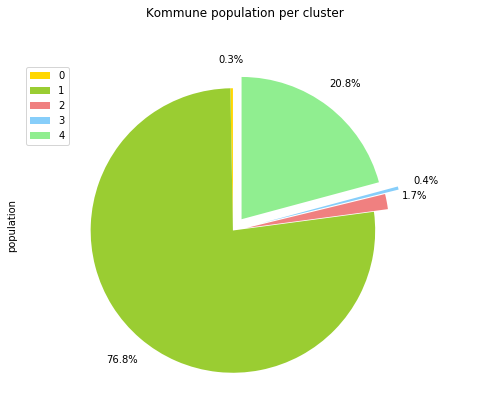

In [375]:
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink']
explode_list = [0, 0, 0.1, 0.2, 0.1] # ratio for each continent with which to offset each wedge.

df_clus_mean['population'].plot(kind='pie',
                            figsize=(8, 6),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=None,       
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.2,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            colors=colors_list,  # add custom colors
                            explode=explode_list # 'explode' lowest 3 continents
                            )

# scale the title up by 12% to match pctdistance
plt.title('Kommune population per cluster', y=1.12) 

plt.axis('equal') 

# add legend
plt.legend(labels=df_clus_mean.index, loc='upper left') 

plt.show()

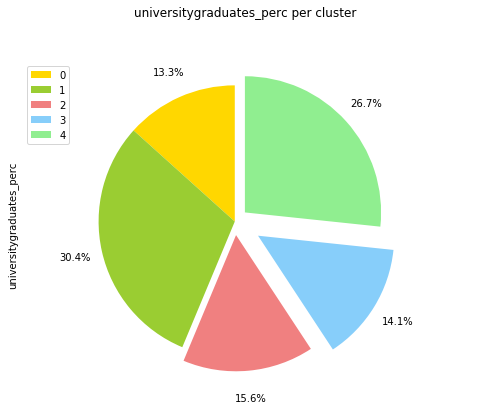

In [376]:
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink']
explode_list = [0, 0, 0.1, 0.2, 0.1] # ratio for each continent with which to offset each wedge.

df_clus_mean['universitygraduates_perc'].plot(kind='pie',
                            figsize=(8, 6),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=None,       
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.2,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            colors=colors_list,  # add custom colors
                            explode=explode_list # 'explode' lowest 3 continents
                            )

# scale the title up by 12% to match pctdistance
plt.title('universitygraduates_perc per cluster', y=1.12) 

plt.axis('equal') 

# add legend
plt.legend(labels=df_clus_mean.index, loc='upper left') 

plt.show()

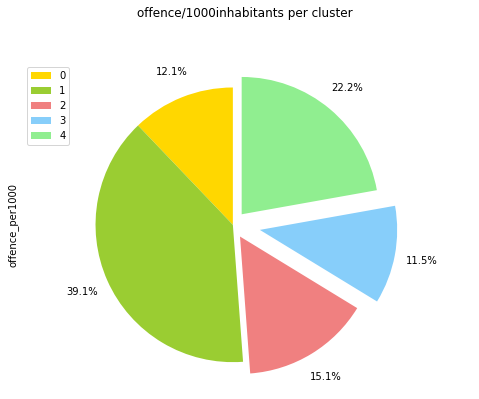

In [377]:
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink']
explode_list = [0, 0, 0.1, 0.2, 0.1] # ratio for each continent with which to offset each wedge.

df_clus_mean['offence_per1000'].plot(kind='pie',
                            figsize=(8, 6),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=None,       
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.2,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            colors=colors_list,  # add custom colors
                            explode=explode_list # 'explode' lowest 3 continents
                            )

# scale the title up by 12% to match pctdistance
plt.title('offence/1000inhabitants per cluster', y=1.12) 

plt.axis('equal') 

# add legend
plt.legend(labels=df_clus_mean.index, loc='upper left') 

plt.show()

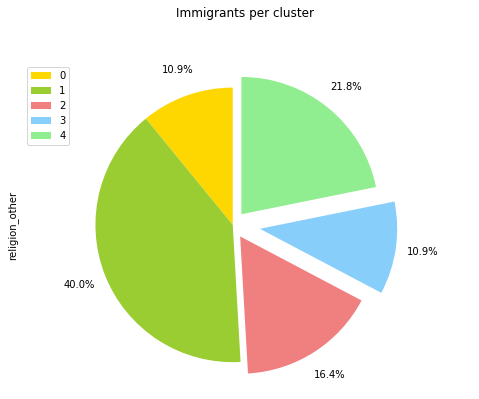

In [378]:
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink']
explode_list = [0, 0, 0.1, 0.2, 0.1] # ratio for each continent with which to offset each wedge.

df_clus_mean['religion_other'].plot(kind='pie',
                            figsize=(8, 6),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=None,       
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.2,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            colors=colors_list,  # add custom colors
                            explode=explode_list # 'explode' lowest 3 continents
                            )

# scale the title up by 12% to match pctdistance
plt.title('Immigrants per cluster', y=1.12) 

plt.axis('equal') 

# add legend
plt.legend(labels=df_clus_mean.index, loc='upper left') 

plt.show()

Let us display all kommunes with its labels to plot education, immigration and crime 

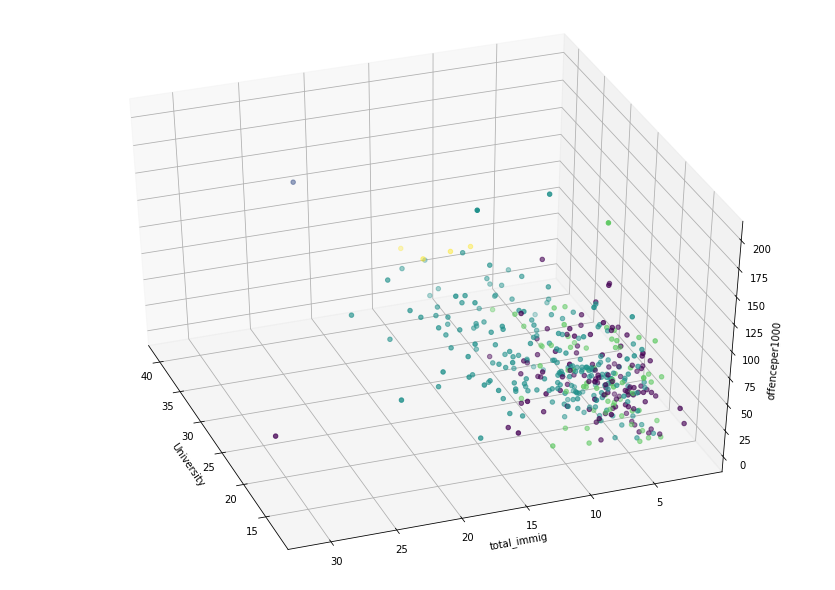

In [405]:
fig = plt.figure(1, figsize=(12, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=40, azim=160)

plt.cla()
# plt.ylabel('Age', fontsize=18)
# plt.xlabel('Income', fontsize=16)
# plt.zlabel('Education', fontsize=16)
ax.set_xlabel('University')
ax.set_ylabel('total_immig')
ax.set_zlabel('offenceper1000')

ax.scatter(X[:, 2], X[:, 3], X[:, 8], c= labels.astype(np.float))

### Let us examine individual clusters

### Cluster1

In [379]:
##### cluster 1 
df_clus1 = df_clus.loc[df_clus['Labels'] == 0]
##Let us tabulate only top 10 
df_clus1.head(10)

kommune kcode  population  universitygraduates_perc  religion_other  \
0      agdenes  5016        1693                     15.59             4.0   
3       alvdal  0438        2418                     18.69             6.9   
9      askvoll  1428        3038                     19.12             3.4   
11    audnedal  1027        1780                     18.03            12.4   
13     aurland  1421        1764                     23.53             4.5   
18  balestrand  1418        1279                     26.74            11.5   
19   ballangen  1854        2470                     14.94             5.5   
22       bardu  1922        4030                     22.66             3.0   
23      beiarn  1839        1022                     12.62             1.8   
27      bindal  1811        1450                     16.14             2.6   

    kommune_income_perc  income_percapita  debt_percapita  \
0                   6.0          111076.0         27390.0   
3                  -1.7          109330.0         99351.0   
9                   4.4          109149.0         77309.0   
11                 -3.0          113584.0         73707.0   
13                  8.2          161686.0         78483.0   
18                 -3.1          162841.0         74969.0   
19                  4.9          111871.0         66794.0   
22                 -3.5          111183.0         94705.0   
23                 -4.1          142546.0         89335.0   
27                 13.7          147776.0         85928.0   

    top10_immigrants_perc  offence_per1000  Labels  
0                    4.78             0.00       0  
3                    4.14            81.29       0  
9                    3.19            19.89       0  
11                   6.85            31.17       0  
13                   6.41            79.52       0  
18                  10.40            23.05       0  
19                   2.55            33.56       0  
22                   3.37            57.52       0  
23                   1.47            21.49       0  
27                   1.93            28.68       0

In [380]:
# create map
map_clusters1 = folium.Map(location=[63.4305 , 10.3922], zoom_start=4)
map_clusters1.choropleth(
    geo_data=kommuner_norge,
    data=df_clus1,
    columns=['kcode','Labels'],
    key_on='properties.kommunenummer',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Cluster1'
)
# display map
map_clusters1

We can do lot of analysis with various combinations. <br>
for example, let us plot the relation between education, immigration and crime rate

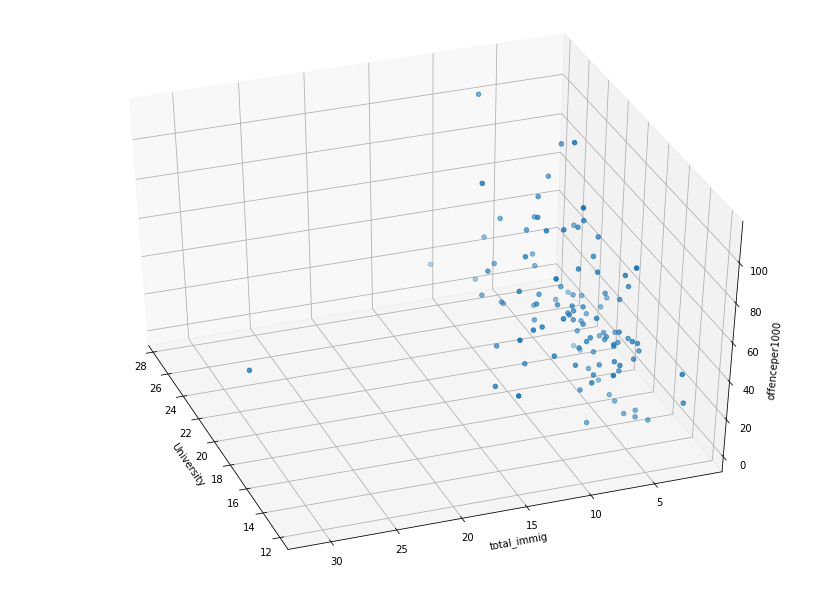

In [394]:
from mpl_toolkits.mplot3d import Axes3D 
C = df_clus1.values[:,1:]
C = np.nan_to_num(C)

fig = plt.figure(1, figsize=(12, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=40, azim=160)

plt.cla()
ax.set_xlabel('University')
ax.set_ylabel('total_immig')
ax.set_zlabel('offenceper1000')

ax.scatter(C[:, 2], C[:, 3], C[:, 8])

### Cluster2

In [382]:
##### cluster 2 
df_clus2 = df_clus.loc[df_clus['Labels'] == 1]
##Let us tabulate only top 10 
df_clus2.head(10)

kommune kcode  population  universitygraduates_perc  religion_other  \
232    oslo  0301      681067                     40.74            21.8   

     kommune_income_perc  income_percapita  debt_percapita  \
232                  5.2           91624.0         39969.0   

     top10_immigrants_perc  offence_per1000  Labels  
232                  14.57            131.5       1

### Cluster3

In [383]:
##### cluster 3 
df_clus3 = df_clus.loc[df_clus['Labels'] == 2]
##Let us tabulate only top 10 
df_clus3.head(10)

kommune kcode  population  universitygraduates_perc  \
2             alta  2012       20665                     24.37   
4            andoy  1871        4771                     17.52   
6          arendal  0906       44784                     24.69   
7            asker  0220       61523                     38.66   
8            askim  0124       15865                     17.50   
10           askoy  1247       29275                     21.63   
14  aurskog-holand  0221       16500                     15.62   
15       austevoll  1244        5212                     18.00   
16       austrheim  1264        2887                     15.45   
17          averoy  1554        5849                     18.28   

    religion_other  kommune_income_perc  income_percapita  debt_percapita  \
2              5.9                  1.4          101891.0         94850.0   
4              9.2                  3.1           96235.0         63120.0   
6             14.3                  1.8           83724.0         87679.0   
7             12.2                  3.8           83144.0          1816.0   
8             16.7                  2.1           79336.0         64859.0   
10             7.3                 -0.2           76685.0         93835.0   
14             9.0                  1.3           73150.0         69041.0   
15             6.7                  6.4           92601.0         97772.0   
16             7.6                  0.4           97984.0         89079.0   
17             4.2                  3.2           81506.0         81027.0   

    top10_immigrants_perc  offence_per1000  Labels  
2                    3.36            67.92       2  
4                    5.07            37.07       2  
6                    6.04            98.52       2  
7                    9.29            50.73       2  
8                   11.40            68.35       2  
10                   5.01            33.64       2  
14                   8.50            42.68       2  
15                   6.24            26.69       2  
16                   7.76            39.26       2  
17                   6.65            34.22       2

In [384]:
# create map
map_clusters3 = folium.Map(location=[63.4305 , 10.3922], zoom_start=4.4)
map_clusters3.choropleth(
    geo_data=kommuner_norge,
    data=df_clus3,
    columns=['kcode','Labels'],
    key_on='properties.kommunenummer',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Cluster3'
)
# display map
map_clusters3

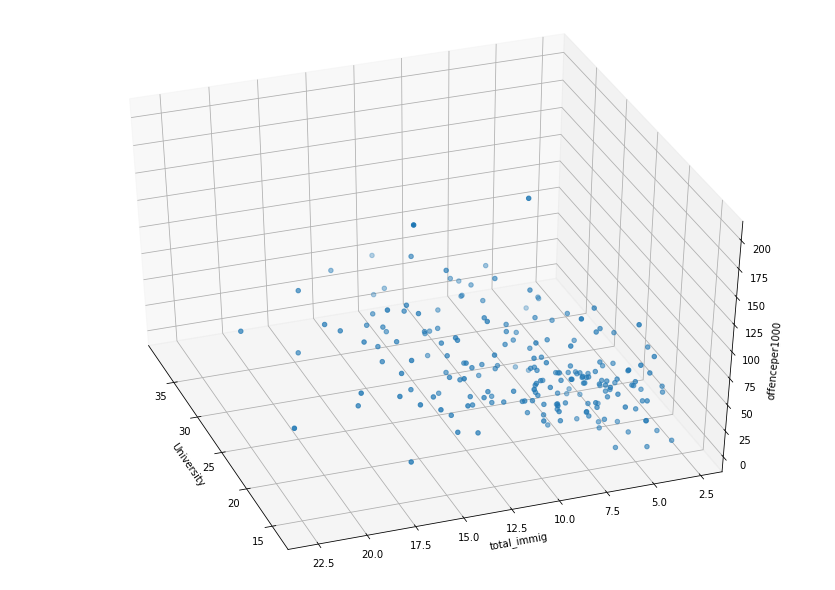

In [393]:
C3 = df_clus3.values[:,1:]
C3 = np.nan_to_num(C3)

fig = plt.figure(1, figsize=(12, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=40, azim=160)

plt.cla()
ax.set_xlabel('University')
ax.set_ylabel('total_immig')
ax.set_zlabel('offenceper1000')

ax.scatter(C3[:, 2], C3[:, 3], C3[:, 8])

### Cluster 4

In [386]:
##### cluster 4 
df_clus4 = df_clus.loc[df_clus['Labels'] == 3]
##Let us tabulate only top 10 
df_clus4.head(10)

kommune kcode  population  universitygraduates_perc  religion_other  \
1     alstahaug  1820        7415                     23.05             6.8   
5       aremark  0118        1357                     15.92             8.2   
12        aukra  1547        3539                     20.26            11.5   
24         berg  1929         888                     16.22             4.7   
26     berlevag  2024         981                     15.09             5.2   
31         bokn  1145         840                     14.05             6.9   
41  deatnu-tana  2025        2900                     20.62             4.8   
44    drangedal  0817        4080                     14.14             9.2   
45        dyroy  1926        1129                     18.51             2.2   
46        donna  1827        1391                     18.91             4.7   

    kommune_income_perc  income_percapita  debt_percapita  \
1                   1.4          105655.0        127095.0   
5                   4.0          105825.0        113797.0   
12                 22.8          170721.0        111839.0   
24                  2.9          156971.0        118521.0   
26                  1.3          164217.0        232304.0   
31                  8.9          129906.0        174849.0   
41                 -1.3          121072.0        154610.0   
44                  0.2           97944.0        113878.0   
45                  8.4          150344.0        110888.0   
46                 12.1          138838.0        107693.0   

    top10_immigrants_perc  offence_per1000  Labels  
1                    5.15            54.17       3  
5                    2.43            54.18       3  
12                   8.62            20.58       3  
24                  10.25            35.86       3  
26                   9.58            67.32       3  
31                   5.24            58.90       3  
41                   2.31            72.53       3  
44                   3.16            63.51       3  
45                   1.24            34.88       3  
46                   4.53            38.24       3

In [387]:
# create map
map_clusters4 = folium.Map(location=[63.4305 , 10.3922], zoom_start=4.4)
map_clusters4.choropleth(
    geo_data=kommuner_norge,
    data=df_clus4,
    columns=['kcode','Labels'],
    key_on='properties.kommunenummer',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Cluster4'
)
# display map
map_clusters4

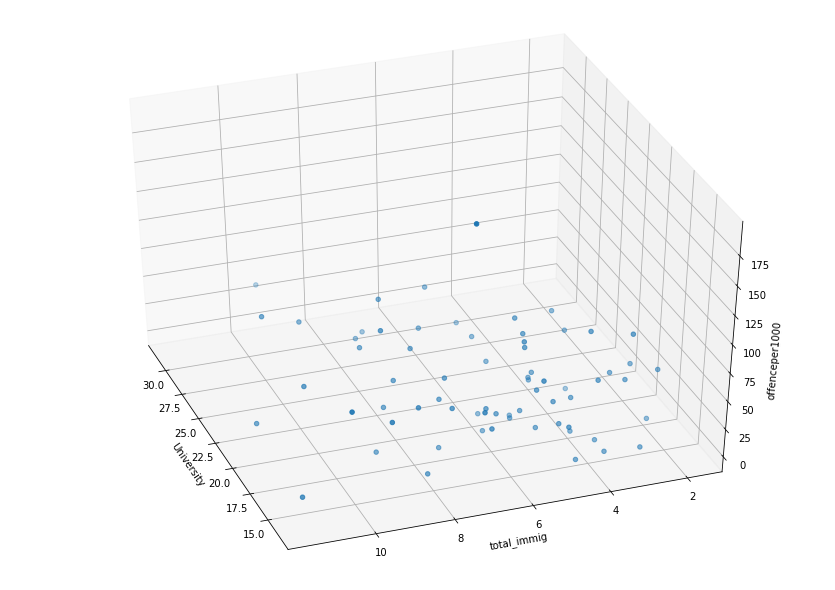

In [395]:
from mpl_toolkits.mplot3d import Axes3D 
C4 = df_clus4.values[:,1:]
C4 = np.nan_to_num(C4)

fig = plt.figure(1, figsize=(12, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=40, azim=160)

plt.cla()
ax.set_xlabel('University')
ax.set_ylabel('total_immig')
ax.set_zlabel('offenceper1000')

ax.scatter(C4[:, 2], C4[:, 3], C4[:, 8])

### Cluster5

In [389]:
##### cluster 5 
df_clus5 = df_clus.loc[df_clus['Labels'] == 4]
##Let us tabulate only top 10 
df_clus5.head(10)

kommune kcode  population  universitygraduates_perc  religion_other  \
25      bergen  1201      281190                     33.76            12.0   
36      baerum  0219      126841                     40.69            13.4   
296  stavanger  1103      134037                     33.94            14.1   
333  trondheim  5001      196159                     35.07             9.9   

     kommune_income_perc  income_percapita  debt_percapita  \
25                   4.3           78957.0         54860.0   
36                   5.3           84027.0         49471.0   
296                  3.5           81170.0         60830.0   
333                  1.5           77797.0         73615.0   

     top10_immigrants_perc  offence_per1000  Labels  
25                    7.06            85.39       4  
36                    9.40            53.31       4  
296                   7.62            81.39       4  
333                   5.69            78.89       4

In [390]:
# create map
map_clusters5 = folium.Map(location=[63.4305 , 10.3922], zoom_start=5)
map_clusters5.choropleth(
    geo_data=kommuner_norge,
    data=df_clus5,
    columns=['kcode','Labels'],
    key_on='properties.kommunenummer',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Cluster5'
)
# display map
map_clusters5

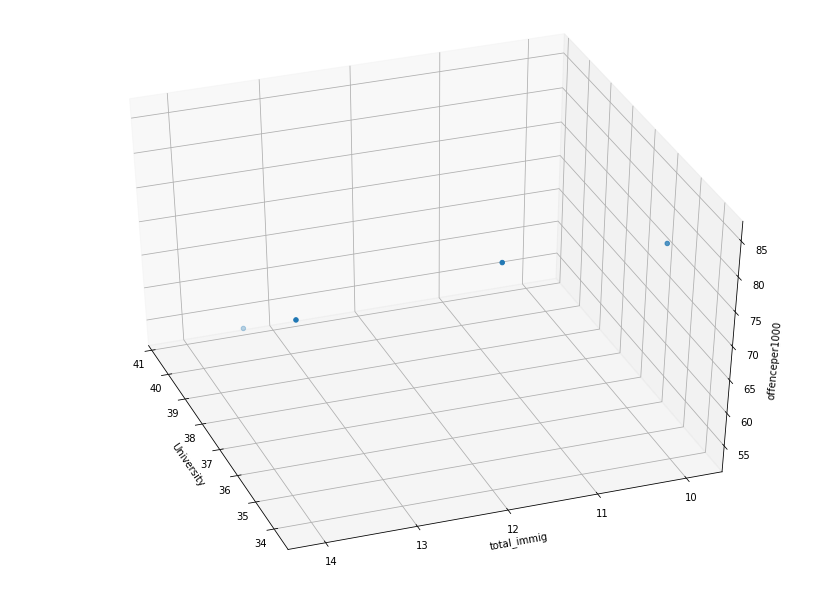

In [396]:
from mpl_toolkits.mplot3d import Axes3D 
C5 = df_clus5.values[:,1:]
C5 = np.nan_to_num(C5)

fig = plt.figure(1, figsize=(12, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=40, azim=160)

plt.cla()
ax.set_xlabel('University')
ax.set_ylabel('total_immig')
ax.set_zlabel('offenceper1000')

ax.scatter(C5[:, 2], C5[:, 3], C5[:, 8])

Empty DataFrame
Columns: [offence/1000, kcode, kommune_c]
Index: []

In [140]:
#df_clus[df_clus.Labels != 1]
#df_clus[df_clus.Labels != 4]
X = df_clus.values[:,2:].astype(int)
X = np.nan_to_num(X)
X[1]

array([  7415,     23,      6,      1, 105655, 127095,      5,     54])

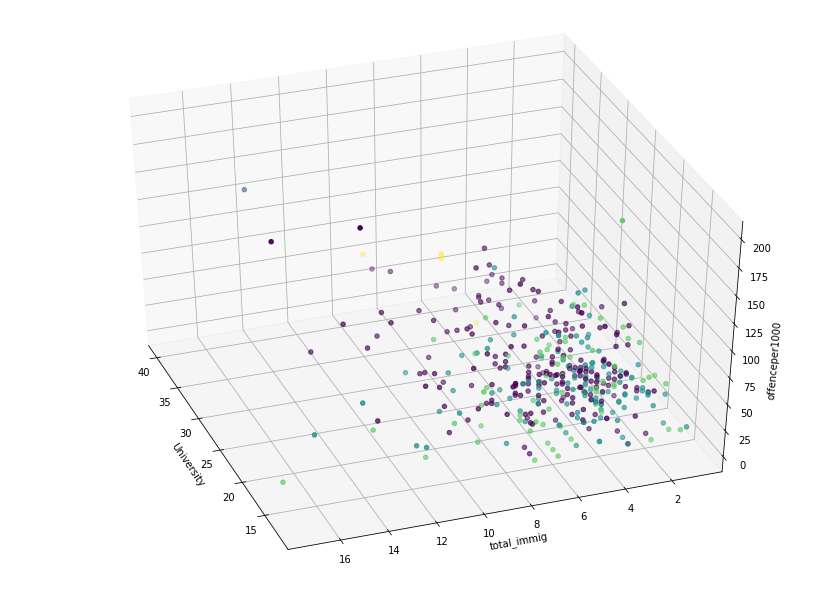

In [193]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(1, figsize=(12, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=40, azim=160)

plt.cla()
# plt.ylabel('Age', fontsize=18)
# plt.xlabel('Income', fontsize=16)
# plt.zlabel('Education', fontsize=16)
ax.set_xlabel('University')
ax.set_ylabel('total_immig')
ax.set_zlabel('offenceper1000')

ax.scatter(X[:, 1], X[:, 6], X[:, 7], c= labels.astype(np.float))

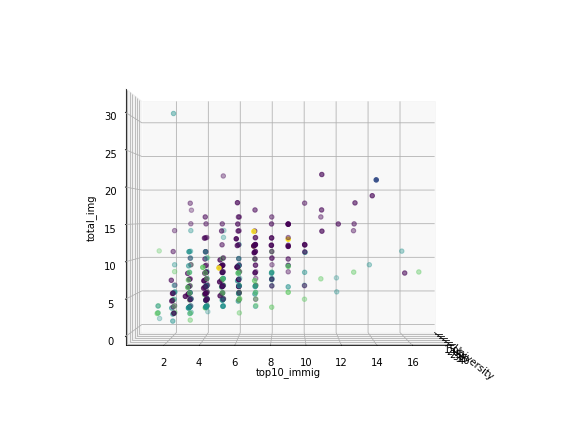

In [182]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=0, azim=0)

plt.cla()
# plt.ylabel('Age', fontsize=18)
# plt.xlabel('Income', fontsize=16)
# plt.zlabel('Education', fontsize=16)
ax.set_xlabel('University')
ax.set_ylabel('top10_immig')
ax.set_zlabel('total_img')

ax.scatter(X[:, 1], X[:, 6], X[:, 2], c= labels.astype(np.float))

